# Náhradní modely v evoluci

Evoluční algortimy dávají často velmi dobré výsledky, jejich použitelnost v praxi ale může omezovat vysoký počat vyhodnocení fitness funkce. U praktických problémů, kde je třeba při každém vyhodnocení dělat nějakou simulaci nebo dokonce experiment je každé vyhodnocení drahé (buď časově, nebo finančně). Tento problém se dá částečně odstratnit tím, že se použijí náhradní modely. Typicky se pokusíme naučit odhadovat hodnoty fitness funkce pomocí nějakého regresního modelu a ten potom používáme místo drahé fitness funkce. Právě způsoby použití náhradních modelů se dnes budeme zabývat.

Začneme jednokriteriální optimalizací, kde je situace v jistém smyslu jednodušší. Nemusíme totiž řešit, co má model modelovat, typicky se modeluje přímo fitness funkce a model se používá k odhadu její hodnoty. Lze použít téměř libovolný model, ale nejčastěji se používají polynomiální modely nízkého stupně, SVM, nebo jednoduché neuronové sítě (typicky RBF). Oblíbeným modelem jsou ale i Gaussovské procesy (aka kriging).

## Gaussovské procesy

Gaussovské procesy jsou třída pravděpodobsnostích modelů, která má jednu velkou výhodu při použití jako náhradní model. Kromě předpovědi umí zároveň poskytnout i konfidenční interval pro tuto předpověď. Toho se dá při optimalizaci využít (často se potom optimalizuje místo fintess funkce, tzv. expected improvement, který právě započítává i nejistotu modelu).

Gaussovské procesy předpokládají, že modelovaná funkce je tvaru $$ G(x) = f(X)^T\beta + Z(X)$$, kde $f(X)^T\beta$ je lineární regresní model a $Z(X)$ je Gaussovský proces s nulovou střední hodnotou a plně stacionární kovarianční funkcí (tj. $C(X,X')=\sigma^2R(|X-X'|)$, kde $\sigma^2$ je rozptyl a $R$ je korelační funkce, která závisí jen na velikosti rozdílu $|X-X'|$). Můžeme si všimnout, že Gaussovské modely jsou vlastně zobecněním lineárního modelu, ten dostaneme z Gaussovského procesu tak, že nastavíme korelační funkci $R=1$ pro $X=X'$ a $R=0$ jinak.

Nakonec už jen stačí odvodit parametry procesu $Z(X)$. Jejich odvození je relativně pracné, koho by zajímal aspoň výsledek (který také není zrovna jednoduchý), nechť se podívá například do [dokumentace ke scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html), nebo do pěkné [knihy od Rassmusena](http://www.gaussianprocess.org/gpml/chapters/RW.pdf).

Zkusme si jen ukázat, jak takový Gaussovský proces pro regresi vypadá.

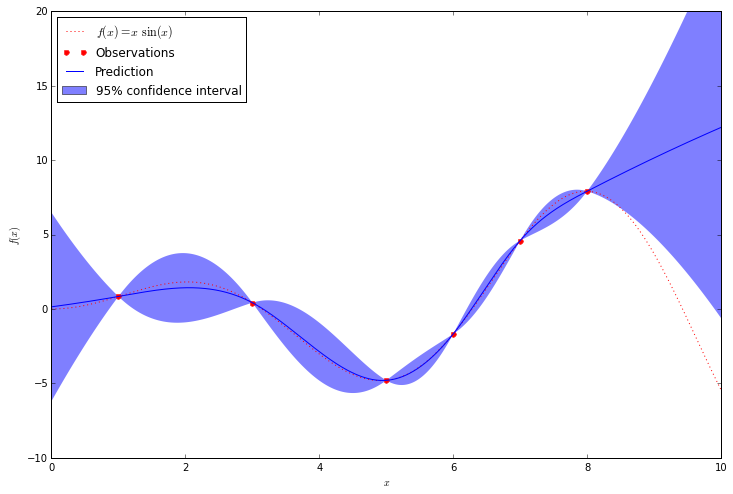

In [18]:
#ukradeno z http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gp_regression.html

%matplotlib inline
import numpy as np
from sklearn.gaussian_process import GaussianProcess
from matplotlib import pyplot as plt

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)
gp.fit(X, y)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)
fig = plt.figure(figsize=(12, 8))
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

## Inicializace počáteční populace

Pro modelování se typicky používají přímo jedinci vytvoření během evoluce, z toho plyne, že špatně nasamplovaná počáteční populace může věst k tomu, že modely se budou špatně trénovat (například, když budou na začátku všichni jedinci u sebe) a je žádoucí, aby jedinci byli rovnoměrně rozmístěni po prohledávaném prostoru. Z toho důvodu se občas používá tzv. Latin Hypercube Sampling - metoda, která zajistí, že rozdělení jedincův každé proměnné bude rovnoměrné (ale ani LHS nezajistí, že bude rovnoměrné v celém prostoru, hlídá jen distribuce pro každou proměnnou).

## Tradiční evoluční algoritmus

Napišme si napřed evoluční algoritmus bez náhradních modelů, ať máme s čím srovnávat. Implementace je ukradena z knihovny deap, kterou také v příkladu používáme. Algoritmus používá jednoduché kódování jedince jako seznamu floatů. Optimalizuje se ackley funkce, minimum má v samých nulách a jeho hodnota je 0.

In [181]:
from deap import creator, base, tools, benchmarks, algorithms
import array, random
import numpy as np

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register('attr', random.uniform, -15, 30)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr, n=10)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', benchmarks.ackley)
toolbox.register('mate', tools.crossover.cxSimulatedBinary, eta=10)
toolbox.register('mutate', tools.mutation.mutGaussian, mu=0, sigma=1.0, indpb=0.8)
toolbox.register('select', tools.selBest)

def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

import pandas as pd
ealogs = pd.DataFrame()

for run in range(0, 10):
    random.seed(run)
    pop=toolbox.population(n=100)

    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, log = eaMuPlusLambda(pop, toolbox, mu=100, lambda_=100, cxpb=0.2, mutpb=0.8, ngen=300, stats=stats, halloffame=hof, verbose=0)
    pdlog = pd.Series(log.select('min'), index=np.cumsum(log.select('nevals')))
    
    ealogs = pd.concat([ealogs, pdlog], axis=1)

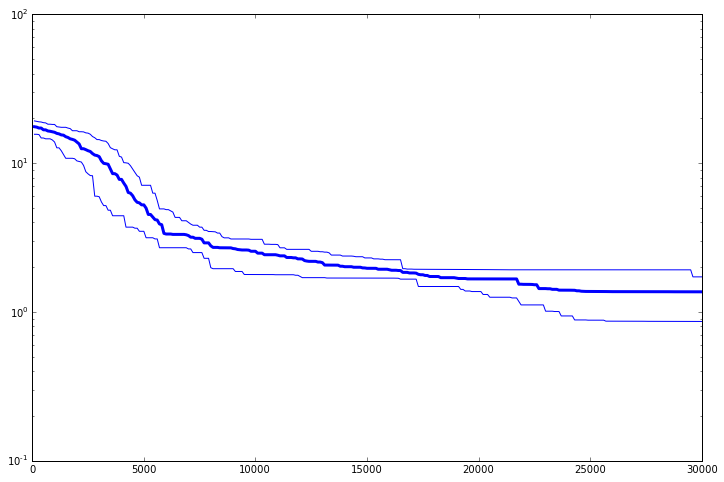

In [182]:
plt.figure(figsize=(12,8))
plt.plot(ealogs.index, ealogs.median(axis=1), lw=3, c='blue')
#plt.fill(np.concatenate(logs.index.values, logs.index.values[::-1]), 
#         np.concatenate(logs.min(axis=1), logs.max(axis=1)[::-1]))
plt.plot(ealogs.index, ealogs.min(axis=1), lw=1, c='blue')
plt.plot(ealogs.index, ealogs.max(axis=1), lw=1, c='blue')
plt.yscale('log')
plt.xlim(0, 30000)
plt.show()

## Nahrazení fitness náhradním modelem (generační model)

Jedním z jednoduchých způsobů využití náhradního modelování je prostě nahradit fitness funkci jejím modelem a používání tohot modelu místo skutečné fitness funkce. Typicky se model používá několik generací a potom se celá populace vyhodnotí skutečnou fitness funkcí. Doufáme, že používání náhradního modelu bude nám pomůže najít aspoň o něco lepší jedince, než jsme měli na počátku aniž bysme potřebovali použít vyhodnocení skutečné fitness funkce.

Upravme teď implementaci algoritmu tak, aby takovou věc dělal. Konkrétně mezi každou generaci vložíme 50 generací, které běží podle náhradního modelu (SVM v tomto případě). Abysme mohli model trénovat, musíme do algoritmu přidat archiv dříve vyhodnocených jedinců. Tento archiv je vhodné udržovat pod nějakou rozumnou velikostí, jinak trénování modelu může trvat dlouho. V našem případě nastavíme limit na 400 jedinců, při prekročení tohoto limitu se nejstarší jedinci z archivu odstraní. V následujícím kódu je přidaná část označena komentářem, jinak je kód stejný jako u běžného evolučního algoritmu.  

In [188]:
from sklearn import linear_model, preprocessing, pipeline, svm
import copy

def eaMuPlusLambdaGenerationalSurrogate(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   archive_size=400, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    
    archive = []
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    archive += invalid_ind # add newly evaluated individuals to archive
    
    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        
        ################## Surrogate part starts here ##########################
        X, y = [list(ind) for ind in archive], [ind.fitness.values[0] for ind in archive] # create training set for surrogate
        
        #clf = pipeline.Pipeline([('poly', preprocessing.PolynomialFeatures(degree=2)), 
        #                         ('linear', linear_model.LinearRegression())])
        clf=svm.SVR()
        clf.fit(X, y)
        
        population2 = copy.deepcopy(population)
        
        # re-evaluate the population with the surrogate
        sur_fitness = clf.predict([list(ind) for ind in population2]) 
        for ind, fit in zip(population2, sur_fitness):
            ind.fitness.values=(fit,)
        
        # Yo, Dawg, I heard you like EA, so I put an EA into your EA so you can EA while you EA
        for sur_gen in range(0, 50):
            offspring = algorithms.varOr(population2, toolbox, lambda_, cxpb, mutpb)

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = clf.predict([list(ind) for ind in invalid_ind])
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = (fit,)
                
            population2[:] = toolbox.select(population2 + offspring, mu)
        
        
        fitnesses = toolbox.map(toolbox.evaluate, population2)
        for ind, fit in zip(population2, fitnesses):
            ind.fitness.values=fit
        
        archive += population2 # add newly evaluated individuals to archive
        if len(archive) > archive_size:
            archive = archive[-archive_size:]
            
        population[:] = toolbox.select(population + population2, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=2*gen-1, nevals=len(population2), **record)
        if verbose:
            print(logbook.stream)
        
        ################## Surrogate part ends here ###############################
        
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # need to evaluate everything, population is evaluated with surrogate
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        archive += invalid_ind # add newly evaluated individuals to archive
        if len(archive) > archive_size:
            archive = archive[-archive_size:]
        
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=2*gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

gsurlogs = pd.DataFrame()
for run in range(0, 10):
    random.seed(run)
    pop=toolbox.population(n=100)

    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)    
    
    pop, log = eaMuPlusLambdaGenerationalSurrogate(pop, toolbox, mu=100, lambda_=100, cxpb=0.2, mutpb=0.8, ngen=150, stats=stats, halloffame=hof, verbose=0)
    pdlog = pd.Series(log.select('min'), index=np.cumsum(log.select('nevals')))
    
    gsurlogs = pd.concat([gsurlogs, pdlog], axis=1)

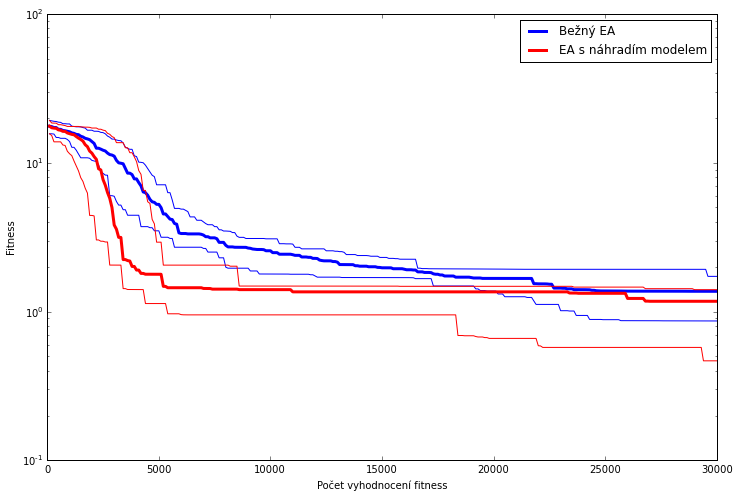

In [231]:
plt.figure(figsize=(12,8))
plt.plot(ealogs.index, ealogs.median(axis=1), lw=3, c='blue', label='Bežný EA')
plt.plot(ealogs.index, ealogs.min(axis=1), lw=1, c='blue')
plt.plot(ealogs.index, ealogs.max(axis=1), lw=1, c='blue')
plt.plot(gsurlogs.index, gsurlogs.median(axis=1), lw=3, c='red', label='EA s náhradím modelem')
plt.plot(gsurlogs.index, gsurlogs.min(axis=1), lw=1, c='red')
plt.plot(gsurlogs.index, gsurlogs.max(axis=1), lw=1, c='red')
plt.yscale('log')
plt.xlim(0, 30000)
plt.yscale('log')
plt.xlabel('Počet vyhodnocení fitness')
plt.ylabel('Fitness')
plt.legend()
plt.show()

## Použití náhradního modelu k předvýběru jedinců

Jinou variantou je použití náhradního modelu k tomu, abysme odhadli, kteří jedinci jsou špatní a tedy jsme je nevyhodnocovali pomocí skutečené fitness funkce. V takovém případě se v každé generaci všichni jedinci vyhodnotí náhradním modelem a ti nejhorší se rovnou považují za nezajímavé a jsou odstraněni. Ostatní jedinci se vyhodnotí pomocí skutečné fitness funkce a projdou normální selekcí.

I tuto metodu zkusíme naprogramovat. V tomto případě opět přidáme archiv na vyhodnocené jedince s velikostí omezenou na 400 a zase použijeme SVM jako náhradní model. Než jedince ohodnotíme pomocí skkutečné fitness funkce, odhadneme ji napřed pomocí modelu. Horší polovinu jedinců potom budeme ignorovat (nastavíme jim vysokou hodnotu a oni díky tomu vyhynou, protože minimalizujeme).

In [213]:
from sklearn import linear_model, preprocessing, pipeline, svm
import copy

def eaMuPlusLambdaGenerationalSurrogate(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   archive_size=400, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    
    archive = []
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    archive += invalid_ind # add newly evaluated individuals to archive
    
    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)
        
        ################## Surrogate part starts here ##########################
        X, y = [list(ind) for ind in archive], [ind.fitness.values[0] for ind in archive] # create training set for surrogate
        
        #clf = pipeline.Pipeline([('poly', preprocessing.PolynomialFeatures(degree=2)), 
        #                         ('linear', linear_model.LinearRegression())])
        clf=svm.SVR()
        clf.fit(X, y)
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # need to evaluate everything, population is evaluated with surrogate
        
        sur_fitness = clf.predict([list(ind) for ind in invalid_ind])
        median = np.median(sur_fitness)
        for ind, fit in zip(invalid_ind, sur_fitness):
            if fit > median:
                ind.fitness.values = (100000,)

        ################ Surrogate part ends here #############################
                
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # need to evaluate everything, population is evaluated with surrogate
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        archive += invalid_ind # add newly evaluated individuals to archive
        if len(archive) > archive_size:
            archive = archive[-archive_size:]
        
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

preslogs = pd.DataFrame()
for run in range(0, 10):
    random.seed(run)
    pop=toolbox.population(n=100)

    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)    
    
    pop, log = eaMuPlusLambdaGenerationalSurrogate(pop, toolbox, mu=100, lambda_=100, cxpb=0.2, mutpb=0.8, ngen=600, stats=stats, halloffame=hof, verbose=0)
    pdlog = pd.Series(log.select('min'), index=np.cumsum(log.select('nevals')))
    
    preslogs = pd.concat([preslogs, pdlog], axis=1)
    
preslogs.fillna(method='ffill', inplace=True)

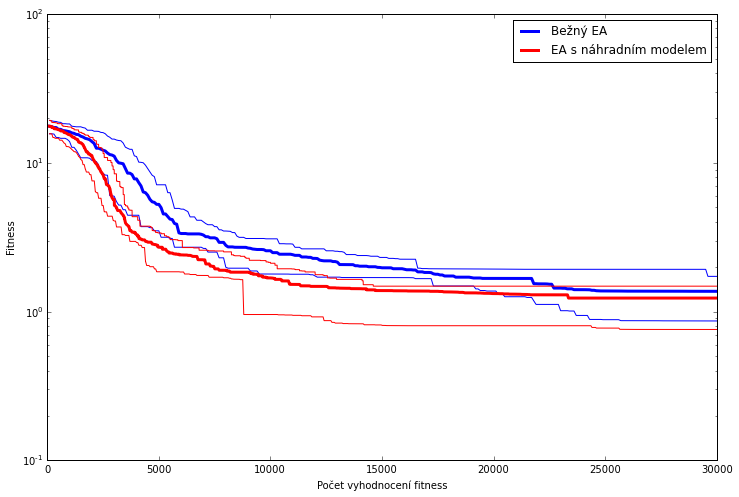

In [229]:
plt.figure(figsize=(12,8))
plt.plot(ealogs.index, ealogs.median(axis=1), lw=3, c='blue', label='Bežný EA')
plt.plot(ealogs.index, ealogs.min(axis=1), lw=1, c='blue')
plt.plot(ealogs.index, ealogs.max(axis=1), lw=1, c='blue')
plt.plot(preslogs.index, preslogs.median(axis=1), lw=3, c='red', label='EA s náhradním modelem')
plt.plot(preslogs.index, preslogs.min(axis=1), lw=1, c='red')
plt.plot(preslogs.index, preslogs.max(axis=1), lw=1, c='red')
plt.yscale('log')
plt.xlabel('Počet vyhodnocení fitness')
plt.ylabel('Fitness')
plt.legend()
plt.yscale('log')
plt.xlim(0, 30000)
plt.show()

## Použití náhradního modelu pro lokální prohledávání

Poslední varianta, v jednokriteriálním případě hodně podobná variantě první, je použití náhradního modelu pro lokální prohledávání. To se typicky implementuje jako mutace, která se snaží najít optimum na náhradním modelu s tím, že začíná z jedince, který je mutován. Nalezené optimum je potom přidáno do populace, kde nahradí původního jedince. Dále se s jedincem pracuje jako v běžném evolučním algoritmu, tj. vyhodnotí se pomocí skutečné fitness. Základní rozdíl od první metody spočívá v tom, že můžeme použít uplnějiný algoritmus pro optimalizaci modelu, místo evolučného algoritmu. Někdy je dokonce možné použít gradientní metody (gradient lze třeba počítat numericky na modelu, to by v případě skutečné fitness funkce vyšlo velmi draho).

Samozřejmě i tuto metodu zkusíme naimplementovat. V každé generaci natrénujeme model (zase SVM s archivem na 400 jedinců) a potom pro několik jedinců (20 %) spustíme Nelder-Mead optimalizační metodu (simplexová metoda, která nepotřebuje gradienty, tradiční matematická metoda), která začíná z jedince, kterého optimalizujeme. Tím najdeme nějaké lokální optimum modelu, kterým nahradíme původního jedince v populaci.

In [219]:
from sklearn import svm
from scipy import optimize
import copy

def eaMuPlusLambdaGenerationalSurrogate(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   archive_size=400, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    
    archive = []
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    archive += invalid_ind # add newly evaluated individuals to archive
    
    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)
        
        ################## Surrogate part starts here ##########################
        X, y = [list(ind) for ind in archive], [ind.fitness.values[0] for ind in archive] # create training set for surrogate
        
        #clf = pipeline.Pipeline([('poly', preprocessing.PolynomialFeatures(degree=2)), 
        #                         ('linear', linear_model.LinearRegression())])
        clf=svm.SVR()
        clf.fit(X, y)
        
        for ind in offspring:
            if random.random() < 0.2:
                ind[:] = optimize.minimize(clf.predict, ind, method='Nelder-Mead').x
        
       
        ################ Surrogate part ends here #############################
                
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # need to evaluate everything, population is evaluated with surrogate
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        archive += invalid_ind # add newly evaluated individuals to archive
        if len(archive) > archive_size:
            archive = archive[-archive_size:]
        
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

lslogs = pd.DataFrame()
for run in range(0, 10):
    random.seed(run)
    pop=toolbox.population(n=100)

    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)    
    
    pop, log = eaMuPlusLambdaGenerationalSurrogate(pop, toolbox, mu=100, lambda_=100, cxpb=0.2, mutpb=0.8, ngen=300, stats=stats, halloffame=hof, verbose=1)
    pdlog = pd.Series(log.select('min'), index=np.cumsum(log.select('nevals')))
    
    lslogs = pd.concat([lslogs, pdlog], axis=1)

gen	nevals	avg    	std     	min    	max    
0  	100   	20.5043	0.796912	16.7633	21.6945
1  	100   	19.9897	0.688783	16.7633	20.6409
2  	100   	19.5813	0.693395	16.7633	20.1949
3  	100   	19.0859	0.78111 	16.7633	19.7732
4  	100   	18.6527	0.760197	16.457 	19.3868
5  	100   	18.0656	0.710942	15.9005	18.9949
6  	100   	17.504 	0.592322	15.7384	18.2713
7  	100   	16.9565	0.390262	15.7384	17.5289
8  	100   	16.5952	0.302847	15.2687	16.9324
9  	100   	16.3445	0.283976	15.2687	16.6171
10 	100   	16.0799	0.263727	15.2687	16.4628
11 	100   	15.7329	0.259395	14.9615	16.0883
12 	100   	15.3928	0.241287	14.9401	15.7381
13 	100   	15.1175	0.231635	14.4664	15.4243
14 	100   	14.8448	0.207244	13.65  	15.0885
15 	100   	14.5575	0.241766	13.65  	14.8687
16 	100   	14.1671	0.291907	13.5918	14.5616
17 	100   	13.9181	0.231898	12.999 	14.2301
18 	100   	13.6403	0.208437	12.6737	13.9124
19 	100   	13.3253	0.315636	12.5006	13.6817
20 	100   	12.8308	0.412557	11.3302	13.4308
21 	100   	12.4344	0.2969  	11.3

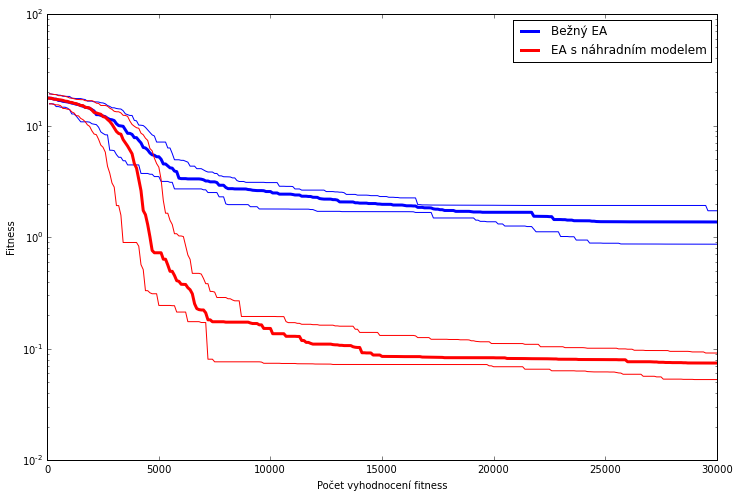

In [228]:
lslogs.fillna(method='ffill', inplace=True)
plt.figure(figsize=(12,8))
plt.plot(ealogs.index, ealogs.median(axis=1), lw=3, c='blue', label='Bežný EA')
plt.plot(ealogs.index, ealogs.min(axis=1), lw=1, c='blue')
plt.plot(ealogs.index, ealogs.max(axis=1), lw=1, c='blue')
plt.plot(lslogs.index, lslogs.median(axis=1), lw=3, c='red', label='EA s náhradním modelem')
plt.plot(lslogs.index, lslogs.min(axis=1), lw=1, c='red')
plt.plot(lslogs.index, lslogs.max(axis=1), lw=1, c='red')
plt.yscale('log')
plt.xlabel('Počet vyhodnocení fitness')
plt.ylabel('Fitness')
plt.legend()
plt.xlim(0, 30000)
plt.show()

## Náhradní modely  ve vícekriteriální optimalizaci

Ve vícekriteriální optimalizaci se také používají náhradní modely. Dokonce máme v tomto případě více možností co a jak modelovat. Nejjednodušší je modelovat každou účelovou funkci samostatně a použít jeden z prvních dvou přístupů popsaných výše, tj. buď nahradit skutečné účelové funkce modelem v několika generacích, nebo použít model pre předvýběr jedinců.

Zajímavou alternativou je použít tzv. agregovaný náhradní model. To je jeden náhradní model, který se snaží nějakým způsobem odhadnou vhdnost jedince pomocí jednoho čísla míst několika funkcí. Existují modely založené na rankSVM (varianta SVM, terá se snaží, aby uspořádání jedinců bylo správné, ale nezáleží na konkrétních hodnotách). Tato varianta se snaží odhadovat, jestli daný jedinec je, nebo není nedominovaný a tak se dá použít k předvýběru jedincú (a dál se  vyhodnocují jen ti nedominovaní).

Další agregovanyý model je založený na odhadu vzdálenosti jedinců od aktuálně nedominovaných, ten se potom dá kromě předvýběru použít i k lokálnímu prohledávání a pomáhá tak zrychlit konvergenci algoritmu.